# DBSCAN

In [ ]:
import numpy as np
from collections import defaultdict

X = np.array([[5, 8], [10, 8], [11, 8], 
              [6, 7], [10, 7], [12, 7], [13, 7],
              [5, 6], [10, 6], [13, 6], [14, 6], 
              [6, 5], [11, 5], [15, 5], 
              [2, 4], [3, 4], [5, 4], [6, 4], [7, 4], [9, 4], [15, 4], 
              [3, 3], [7, 3], 
              [8, 2]])

labels = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'n', 'k', 'm', 'o', 'p', 'q', 'r', 's', 't', 'l', 'u', 'v', 'w', 'x'])

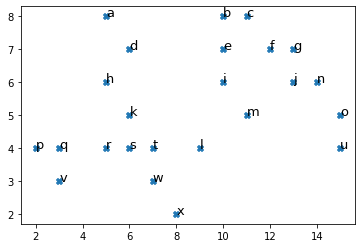

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], marker='X')

for i, l in enumerate(labels):
    ax.annotate(l, (X[i, 0], X[i, 1]), fontsize=13)

In [3]:
def dist(a, b):
    return np.linalg.norm(a - b)

class DBSCAN:
    def __init__(self, X, labels, eps, minpts, distF):
        self.X = X
        self.labels = labels
        self.eps = eps
        self.minpts = minpts
        self.distF = distF
        self.core_points = defaultdict(list)
        self.border_points = defaultdict(list)
        self.visited = set()
        self.path = []
        self.cluster_ids = []
        for i in range(X.shape[0]):
            self.cluster_ids.append(-1)
        
    def __find_special_points(self):
        for i, x in enumerate(self.X):
            self.__save_if_core_point(i)
        self.__find_border_points()
            
    def __save_if_core_point(self, index):
        cnt = 0
        for i, x in enumerate(self.X):
            if i == index:
                continue
            if self.distF(X[i], X[index]) <= self.eps:
                self.core_points[index].append(i)
        if len(self.core_points[index]) < self.minpts:
            del self.core_points[index]
        
    def __find_border_points(self):
        for k, v in self.core_points.items():
            for e in v:
                self.border_points[e].append(k)
                
    def __is_density_reachable(self, s, e):
        '''
            Find path from s to e where e is a core point
            if self.path is not empty then s density reachable from e
            otherwise not
        '''
        if e not in self.core_points:
            return False
        if s == e:
            return True
        self.visited = set()
        self.visited.add(s)
        self.path = []
        self.path.append(s)
        self.__find_path(s, e)
        self.visited = set()
        # not density reachable
        if len(self.path) == 1:
            self.path = []
        return self.path
    
    def __is_density_connected(self, s, e):
        '''
            Returns intermediet core point (index) if there is one
            otherwise -1
        '''
        for k, _ in self.core_points.items():
            if self.__is_density_reachable(s, k) and self.__is_density_reachable(e, k):
                return k
        return -1
    
    def __find_path(self, s, e):
        l = self.border_points[s]
        for i in l:
            if i == e:
                self.path.append(e)
                return
            
        for i in l:
            if i in self.visited:
                continue
            self.visited.add(i)
            self.path.append(i)
            self.__find_path(i, e)
            if self.path[-1] == i:
                # delete last element
                self.path = self.path[:-1]
            elif self.path[-1] == e:
                return
            
    
    def display_core_points(self):
        if len(self.core_points) == 0:
            self.__find_special_points()
        for k, v in self.core_points.items():
            print(f'core: {self.labels[k]}')
            for e in v:
                print(f'\t{self.labels[e]}')
                
    def __display_path(self):
        n = len(self.path)
        for i in range(n - 1):
            print(f'{self.labels[self.path[i]]} -> ', end =" ")
        print(f'{self.labels[self.path[n - 1]]}', end =" ")
        print()
        
    def get_labels_index(self, a, b):
        i = 0
        j = 0
        for k, e in enumerate(self.labels):
            if a == e:
                i = k
            if b == e:
                j = k
        return i, j
                
    def is_density_reachable(self, a, b):
        i, j = self.get_labels_index(a, b)
        if self.__is_density_reachable(i, j):
            self.__display_path()
            return
        print(f'{a} and {b} are not density reachable')
        
    def is_density_connected(self, a, b):
        i, j = self.get_labels_index(a, b)
        core_point_index = self.__is_density_connected(i, j)
        if core_point_index == -1:
            print(f'{a} and {b} are not density connected')
            return
        print(" ----> density connected paths")
        self.__is_density_reachable(i, core_point_index)
        self.__display_path()
        self.__is_density_reachable(j, core_point_index)
        self.__display_path()
        print(" ----> end density connected paths")
        
    def find_clusters(self):
        self.__find_special_points()
        c_id = 0
        for k, v in self.core_points.items():
            # no cluster ID
            if self.cluster_ids[k] == -1:
                c_id += 1
                self.assign_cluster_id(k, c_id)
        return self.cluster_ids
                
    def assign_cluster_id(self, k, c_id):
        if self.cluster_ids[k] != -1:
            return
        self.cluster_ids[k] = c_id
        points = self.core_points[k]
        for p in points:
            if p in self.core_points:
                self.assign_cluster_id(p, c_id)
            else:
                self.cluster_ids[p] = c_id
                
    def display_clusters(self):
        fig, ax = plt.subplots(figsize=(10,10))
        ax.scatter(X[:, 0], X[:, 1], marker='X')
        cluster_markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
        color_map = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], s=110, marker=cluster_markers[self.cluster_ids[i] - 1], c=color_map[self.cluster_ids[i] - 1])
        
        if self.labels is not None:
            for i, l in enumerate(self.labels):
                ax.annotate(l, (X[i, 0], X[i, 1]), fontsize=13)
            
        plt.show()

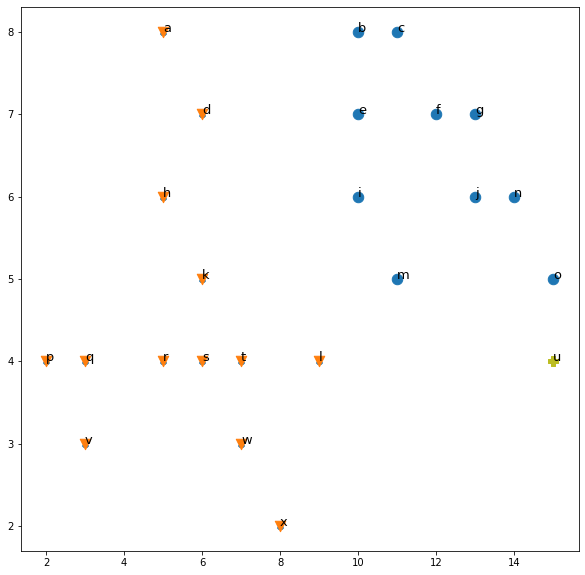

In [4]:
d = DBSCAN(X, labels, 2, 3, dist)
d.find_clusters()
d.display_clusters()
#------------------
# d.display_core_points()
# d.is_density_reachable('m', 'c')
# d.is_density_reachable('u', 'c')
# d.is_density_reachable('o', 'i')
# d.is_density_reachable('p', 'w')
# d.is_density_reachable('x', 'g')
# d.is_density_reachable('x', 'b')
# d.is_density_reachable('l', 'n')
# d.is_density_reachable('m', 'd')
# d.is_density_reachable('m', 'q')
# d.is_density_connected('l', 'x')
# d.is_density_connected('m', 'o')
# d.is_density_connected('x', 'v')
# d.is_density_connected('l', 'u')
# d.is_density_connected('m', 'h')
# d.is_density_connected('j', 'q')
# d.is_density_connected('q', 'j')

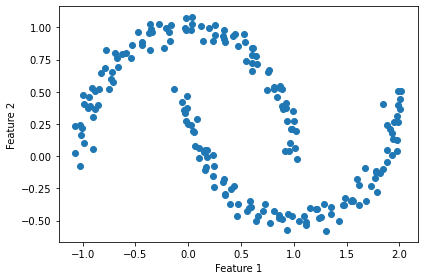

In [5]:
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

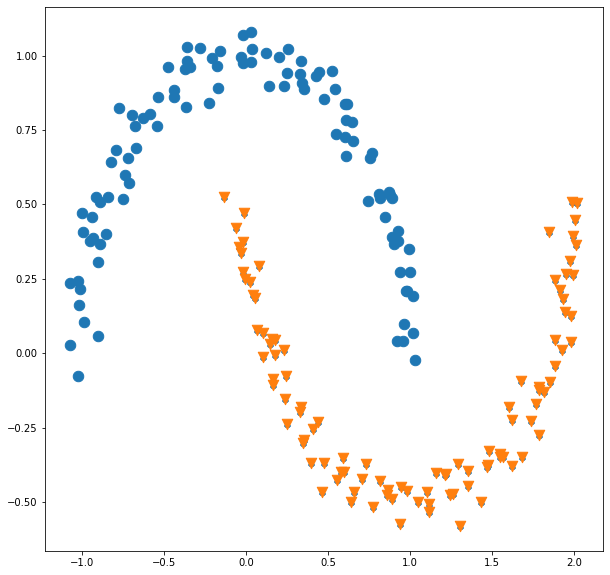

In [6]:
d = DBSCAN(X, None, 0.2, 5, dist)
d.find_clusters()
d.display_clusters()

# PDF estimation

### KNN estimator

In [47]:
from sklearn.neighbors import NearestNeighbors

# 1D case
def PDF_knn_estimator(x, k, D):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(D)
    dist, points = neigh.kneighbors(np.array([[x]]))
    # k / (n * 2 * R) , R - kth NN
    return k / (D.shape[0] * 2 * dist.squeeze()[k - 1])
              

In [69]:
data = np.array([2, 2.5, 3, 4, 4.5, 5, 6.1]).reshape((-1, 1))
for e in data:
    print(PDF_knn_estimator(e[0], 4, data))

0.14285714285714285
0.19047619047619047
0.2857142857142857
0.2857142857142857
0.19047619047619047
0.2597402597402604
0.13605442176870755


In [71]:
# find pick density TODO

### kernel based PDF estimator

In [95]:
def PDF_estimator(x, K, h, D):
    # D - 2d numpy array 
    s = 0
    for i in range(D.shape[0]):
        s += K((x - D[i, :]) / h)
    return s / (D.shape[0] * np.power(h, D.shape[1]))

def find_density_attractor(x, K, h, D, eps):
    x_t = x
    while True:
        k_sum = 0
        x_i_sum = 0
        for i in range(D.shape[0]):
            k_sum += K((x_t - D[i, :]) / (h + 0.0))
            x_i_sum += D[i, :] * K((x_t - D[i, :]) / (h + 0.0))
        x_new_t = x_i_sum / k_sum
        if np.linalg.norm(x_new_t - x_t) <= eps:
            return x_t
        x_t = x_new_t
            

In [96]:
def K1(x):
    if x.max() <= 1:
        return 1
    return 0

def K2(x):
    if np.linalg.norm(x, ord=1):
        return 1
    return 0

In [97]:
X = np.array([[5, 8], [6, 7], [6, 5], [7, 5], [2, 4], [3, 4], [5, 4], [7, 4], [9, 4], [3, 3], [8, 2]])
labels = np.array(['a', 'b', 'c', 'k', 'd', 'e', 'f', 'g', 'h', 'i', 'j'])

#### PDF @ 'e'

In [98]:
PDF_estimator(X[5], K1, 2, X)

11 2


0.25

In [93]:
PDF_estimator(X[5], K2, 2, X)

0.22727272727272727

#### atractor for the 'e'

In [94]:
find_density_attractor(X[5], K1, 2, X, 0.001)

array([6.42857143, 5.28571429])

# DENCLUE

(200, 2)


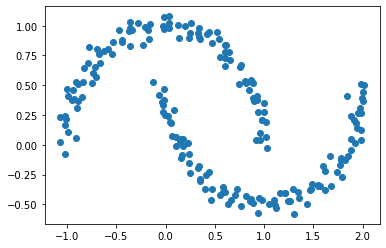

In [238]:
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform

X = np.array([[5, 8], [10, 8], [11, 8], 
              [6, 7], [10, 7], [12, 7], [13, 7],
              [5, 6], [10, 6], [13, 6], [14, 6], 
              [6, 5], [11, 5], [15, 5], 
              [2, 4], [3, 4], [5, 4], [6, 4], [7, 4], [9, 4], [15, 4], 
              [3, 3], [7, 3], 
              [8, 2]])

labels = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'n', 'k', 'm', 'o', 'p', 'q', 'r', 's', 't', 'l', 'u', 'v', 'w', 'x'])

from sklearn.datasets import make_moons


X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
print(X.shape)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [263]:
def gaussian(a):
    return (1 / np.power(6.28, X.shape[0] / 2.0)) * np.exp(-0.5 * np.dot(a.transpose(), a))

class DENCLUE:
    def __init__(self, X, labels, eps, h, kernel, eps_dist):
        self.X = X
        self.labels = labels
        self.eps = eps
        self.h = h
        self.kernel = kernel
        self.eps_dist = eps_dist
        self.attractors = np.empty((X.shape[0], X.shape[1]))

    def __find_attractors(self):
        for i, _ in enumerate(self.X):
            self.__find_attractor(i)
            
    def __find_attractor(self, index):
        x_t = self.X[index]
        t = 0
        while True:
            k_sum = 0
            x_i_sum = 0
            for i in range(self.X.shape[0]):
                k_sum += self.kernel((x_t - self.X[i, :]) / (self.h + 0.0))
                x_i_sum += self.X[i, :] * self.kernel((x_t - self.X[i, :]) / (self.h + 0.0))
            x_new_t = x_i_sum / k_sum
            if np.linalg.norm(x_new_t - x_t) <= 0.0001:
                if self.__estimate_PDF(x_new_t) >= self.eps:
                    self.attractors[index] = x_new_t
                return
            x_t = x_new_t
            t += 1
            
    def __estimate_PDF(self, x):
        s = 0
        for i in range(self.X.shape[0]):
            s += self.kernel((x - self.X[i, :]) / self.h)
        return s / (self.X.shape[0] * np.power(self.h, self.X.shape[1]))
    
    def display(self):
        self.__find_attractors()
        y_0 = []
        y_1 = []
        for i, e in enumerate(self.attractors):
            if self.__estimate_PDF(e) >= 0.8 * 1e-78:
                y_0.append(self.attractors[i][0])
                y_1.append(self.attractors[i][1])
        plt.scatter(self.X[:, 0], self.X[:, 1])
        plt.scatter(y_0, y_1, c='#17becf', marker='X', s=210)
        plt.show()
        
# TODO merge points with close attractors

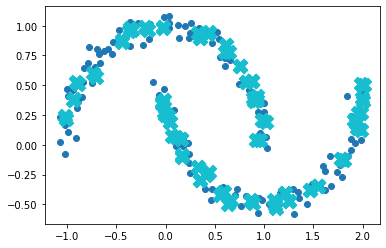

In [264]:
d = DENCLUE(X, None, 0.8 * 1e-78, 0.01, gaussian, 2.09)
d.display()